In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
import warnings
import zipfile

from tqdm import tqdm
from joblib import dump, load
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib.ticker import FuncFormatter

# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [ ]:
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 15)
rs = 42

Можно распаковать zip файл с обученными моделями, либо обучить их снуля

In [ ]:
with zipfile.ZipFile('models.zip', 'r') as zip_obj:
   zip_obj.extractall()

Сразу сделаем все необходимые папки. Если вы распаковали zip файл с моделями, то делать папку models_svr не нужно - она уже имеется.

In [ ]:
# !mkdir models_svr
# !mkdir models_svr/models_h6
# !mkdir models_svr/models_h10
# !mkdir models_svr/models_h14

# !mkdir exetended_harmonic_data  # для дополненных мл моделью данных

In [ ]:
# !mv svr_h10.csv ./exetended_harmonic_data/  # Для перемещения файлов в другие папки

In [ ]:
shape = pd.read_csv('shape.csv')
gradient = pd.read_csv('gradients.csv', index_col='ts')

df = shape.merge(gradient, how='inner', on='id')#[['Rightchamfer', 'Leftchamfer', 'h2', 'h6', 'h10', 'h14']]
df.sample(6).T

,149,275,725,125,203,613
id,1.490000000000000e+02,2.750000000000000e+02,7.250000000000000e+02,1.250000000000000e+02,2.030000000000000e+02,6.130000000000000e+02
Rightchamfer,1.290409677419355e+00,2.580719354838710e+00,7.096803225806451e+00,9.678322580645160e-01,1.935564516129032e+00,6.129070967741935e+00
Leftchamfer,1.354841935483871e+01,1.225810322580645e+01,1.354841935483871e+01,1.870968387096774e+01,7.096838709677419e+00,3.225890322580645e+00
h0,8.836247705756860e-18,5.421010862427520e-19,2.032879073410320e-20,8.917562868693269e-18,8.931115395849340e-18,5.421010862427520e-18
h1,1.192945036898820e-17,2.654596179126490e-17,9.723789253864970e-18,2.033268133664900e-17,1.901533220902210e-17,2.463067061614650e-17
h2,1.311024111442840e-01,1.294576718841160e-01,1.226368498014680e-01,1.303811789287660e-01,1.323273876858360e-01,1.329549606592660e-01
h3,6.045181549666520e-18,3.304978154465520e-17,3.358950069288260e-17,7.263986349625689e-18,1.079221047360720e-17,8.770500485558789e-18
h4,1.934404049136740e-17,6.782650138681920e-18,1.690379081233500e-17,1.108015757444910e-17,6.101669879226550e-18,1.745983008223190e-17
h5,6.500839353150730e-18,1.919027950089940e-17,2.418111481670680e-17,2.053877696177470e-17,1.278697484447540e-17,2.004078414515670e-17
h6,6.375961314335890e-03,2.884327534794010e-03,7.487451968687280e-03,7.099331263214550e-03,7.592125014057650e-03,8.717385155616370e-03


In [ ]:
df['h6/h2'] = (df['h6'] / df['h2'])
df['h10/h2'] = ((df['h10'] / df['h2']))
df['h14/h2'] = ((df['h14'] / df['h2']))

# Отнормируем для одновременного зануления 3х метрик. Все модели обучены для нормированных данных

df['h6/h2'] = (df['h6/h2'] - df['h6/h2'].min()) / (df['h6/h2'].max() - df['h6/h2'].min())
df['h10/h2'] = (df['h10/h2'] - df['h10/h2'].min()) / (df['h10/h2'].max() - df['h10/h2'].min())
df['h14/h2'] = (df['h14/h2'] - df['h14/h2'].min()) / (df['h14/h2'].max() - df['h14/h2'].min())

In [ ]:
df[['Rightchamfer', 'Leftchamfer', 'h6/h2', 'h10/h2', 'h14/h2']].sample(6)

,Rightchamfer,Leftchamfer,h6/h2,h10/h2,h14/h2
498,4.838761290322580,11.612945161290320,0.095790521035484,0.574840073847391,0.388212064483510
188,1.612987096774193,18.064525806451613,0.278396437952412,0.007213357489774,0.234731902949868
896,9.032267741935485,0.000100000000000,0.682324402692799,0.030612273224792,0.189330768827312
628,6.129070967741935,12.903261290322581,0.332440204031440,0.425479135739270,0.543397776035960
617,6.129070967741935,5.806522580645161,0.316519552114485,0.659518884162980,0.356521150641184
428,4.193606451612903,7.741996774193548,0.243717107425082,0.660637092030256,0.161417010411741


Изобразим тепловую карту гармоник для точек, вычисленных в Opera

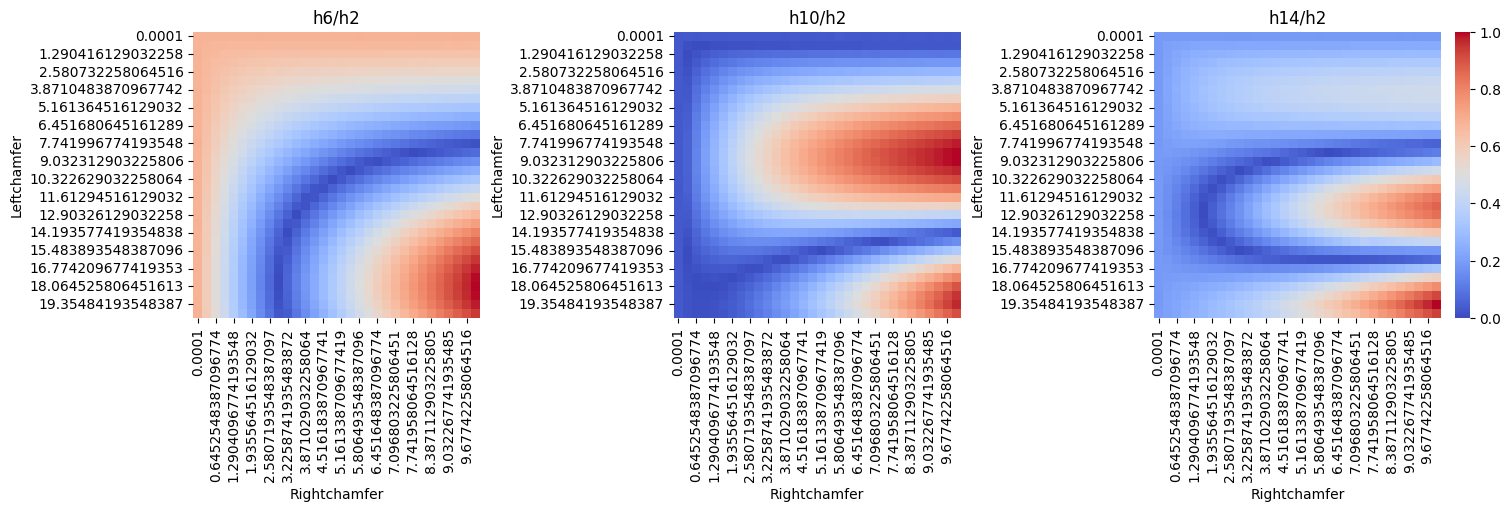

In [ ]:
pivot_h6_raw_data = pd.pivot_table(df, index='Leftchamfer', columns='Rightchamfer', values='h6/h2', aggfunc='mean')
pivot_h10_raw_data = pd.pivot_table(df, index='Leftchamfer', columns='Rightchamfer', values='h10/h2', aggfunc='mean')
pivot_h14_raw_data = pd.pivot_table(df, index='Leftchamfer', columns='Rightchamfer', values='h14/h2', aggfunc='mean')

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)  # 1 строка, 3 столбца

# Heatmap 1
sns.heatmap(
    pivot_h6_raw_data,
    ax=axes[0],
    cmap="coolwarm",
    cbar=False  # Цветовая шкала только для последнего графика
)
axes[0].set_title("h6/h2")

# Heatmap 2
sns.heatmap(
    pivot_h10_raw_data,
    ax=axes[1],
    cmap="coolwarm",
    cbar=False
)
axes[1].set_title("h10/h2")

# Heatmap 3
sns.heatmap(
    pivot_h14_raw_data,
    ax=axes[2],
    cmap="coolwarm"
)
axes[2].set_title("h14/h2")

plt.show()

Попробуем найти точку наименьшей суммы отнормированных метрик перебором, чтобы понять порядок ее координат

In [ ]:
minumum = 10

for i in tqdm(range(df['h6/h2'].shape[0])):
    if (df['h6/h2'].iloc[i] + df.iloc[i]['h10/h2'] + df.iloc[i]['h14/h2']) < minumum:
        minumum = df.iloc[i]['h6/h2'] + df.iloc[i]['h10/h2'] + df.iloc[i]['h14/h2']
        row_raw = i

100%|██████████| 1024/1024 [00:00<00:00, 6894.01it/s]


In [ ]:
rightchamfer_raw, leftchamfer_raw = df.iloc[row_raw][['Rightchamfer', 'Leftchamfer']].values.flatten()
rightchamfer_raw, leftchamfer_raw

(2.9032967741935485, 15.483893548387096)

Далее настроим валидацию и раскидаем на процентили

In [ ]:
N_folds = 10
target_name = 'h10/h2'

df['target_reg_group'] = pd.qcut(df[target_name], N_folds, labels = [f'group_{i}' for i in range(N_folds)])

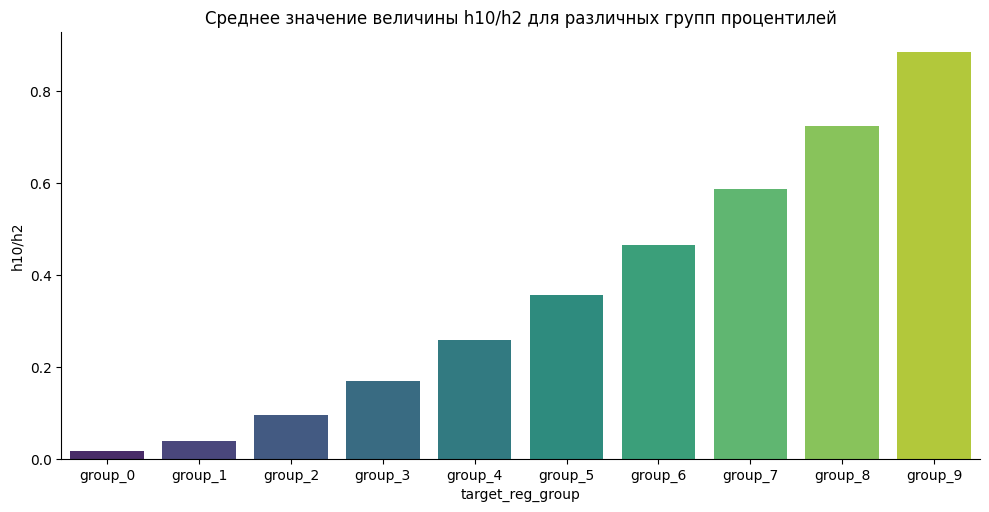

In [ ]:
tmp = df.groupby('target_reg_group', as_index=False)[target_name].agg('mean')

num_groups = tmp['target_reg_group'].nunique()
palette = sns.color_palette("viridis", num_groups)

sns.catplot(
    data=tmp,
    x='target_reg_group',
    y=target_name,
    aspect=2,
    kind="bar",
    palette=palette
);

plt.title(f'Среднее значение величины {target_name} для различных групп процентилей')
plt.show()

In [ ]:
df_train, df_test, y, y_test = train_test_split(df[['Rightchamfer', 'Leftchamfer', 'target_reg_group']],
                                                    df[target_name], test_size=0.2, random_state=rs, stratify=df['target_reg_group'])

groups = df_train['target_reg_group']
x = df_train[['Rightchamfer', 'Leftchamfer']]

x_mean = x.mean()
x_std = x.std()
x = (x - x_mean) / x_std
df_test = (df_test[['Rightchamfer', 'Leftchamfer']] - x_mean) / x_std

x = pd.concat([x, groups], axis=1)

# Попробуем разные методы регрессии на простом train_test_split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=rs, stratify=groups, shuffle=True)
x_train = x_train.drop(columns=['target_reg_group'])
x_val = x_val.drop(columns=['target_reg_group'])

Нейронка - очень плохо

In [ ]:
# def rmse(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(y_pred - y_true)))

# input = Input(shape=[x_train.shape[1]])
# d = Dense(10, activation='sigmoid')(input)
# d = Dense(6, activation='sigmoid')(d)
# d = Dense(1, activation='linear')(d)


# model = Model(input, d)
# model.compile(optimizer='adam', loss=rmse)
# print(model.summary())

# histoty = model.fit(x_train, y_train, epochs=60, verbose=1,
#                     validation_data=(x_val, y_val), batch_size=131)

# y_pred = model.predict(x_val)
# print(r2_score(y_pred, y_val))

# plt.plot(histoty.history['loss'][10:], label='loss')
# plt.plot(histoty.history['val_loss'][10:], label='val_loss')
# plt.legend()

SVR - очень хорошо)

In [ ]:
# model = SVR(kernel='rbf', C=10, epsilon=0.0001, gamma=8.5)  # для h6/h2, скор 0.99915
# model = SVR(kernel='rbf', C=10, epsilon=0.0001, gamma=8.6)  # для h10/h2, скор 0.99892
# model = SVR(kernel='rbf', C=10, epsilon=0.00001, gamma=9.5)  # для h14/h2, скор 0.99519


model = SVR(kernel='rbf', C=10, epsilon=0.00001, gamma=9.5)  # для h14/h2, скор 0.99519
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
print(f'val_score: {r2_score(y_val, y_pred)}')

y_pred = model.predict(df_test)
print(f'test_score: {r2_score(y_test, y_pred)}')

val_score: 0.997342471780263
test_score: 0.9926159935633307


# А тут уже на kfold

In [ ]:
skf = StratifiedKFold(n_splits=N_folds, shuffle=True, random_state=rs)
scores = []
models = []

for i, (train, val) in enumerate(skf.split(x, x['target_reg_group'])):
    x_train, x_val = x.drop(columns=['target_reg_group']).iloc[train].values, x.drop(columns=['target_reg_group']).iloc[val].values
    y_train, y_val = y.iloc[train], y.iloc[val]

    # model = LinearRegression()
    # model = CatBoostRegressor(iterations=1000,
    #                           depth=10,
    #                           loss_function='MAE',
    #                           verbose=False,
    #                           random_state=rs,
    #                           learning_rate=0.145)
    # model = LGBMRegressor(n_estimators=1000,
    #                       max_depth=10,
    #                       learning_rate=0.145,
    #                       random_state=rs,
    #                       metric='mse',
    #                       verbose=0)

    # Здесь нужно указать правильную модель для h2, h10 или h14 соответственно
    model = SVR(kernel='rbf', C=100, epsilon=0.00001)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_val)

    models.append(model)
    scores.append(r2_score(y_val, y_pred))

    print(f'Fold {i + 1}/{N_folds} score: {r2_score(y_val, y_pred)}')

scores = np.array(scores)
print(f'Mean score: {scores.mean()}, std: {scores.std()}')

Fold 1/10 score: 0.9685987751919439
Fold 2/10 score: 0.9925903847377674
Fold 3/10 score: 0.9943730783508492
Fold 4/10 score: 0.9896086330317561
Fold 5/10 score: 0.9876868353450382
Fold 6/10 score: 0.9971202056069698
Fold 7/10 score: 0.991173322877061
Fold 8/10 score: 0.9804464355252631
Fold 9/10 score: 0.988994355763428
Fold 10/10 score: 0.987745694656878
Mean score: 0.9878337721086954, std: 0.0076932608056292425


In [ ]:
def full_predict(models, x):
    y_pred = np.zeros((x.shape[0]))

    for model in models:
        y_pred += model.predict(np.array(x))
    return y_pred / N_folds

y_pred = full_predict(models, df_test)
print(f'r2 is {r2_score(y_test, y_pred)}')

r2 is 0.9820703347208242


In [ ]:
# для записи измените подпапку
for i, model in enumerate(models, 1):
    dump(model, f'models_svr_2/models_h10/model_{i}.joblib')

In [ ]:
!ls models_svr_2/models_h14

model_10.joblib  model_2.joblib  model_4.joblib  model_6.joblib  model_8.joblib
model_1.joblib	 model_3.joblib  model_5.joblib  model_7.joblib  model_9.joblib


Сохранить модели в зип папку, если вы их обучали

In [ ]:
# !zip -r models_2.zip models_svr_2

Прочитаем модели (**обртите внимание на путь**)

In [ ]:
models_h6 = [0] * N_folds
models_h10 = [0] * N_folds
models_h14 = [0] * N_folds


for i in range(N_folds):
    models_h6[i] = load(f'models_svr_2/models_h6/model_{i + 1}.joblib')
    models_h10[i] = load(f'models_svr_2/models_h10/model_{i + 1}.joblib')
    models_h14[i] = load(f'models_svr_2/models_h14/model_{i + 1}.joblib')

# all_models = [models_h6, models_h14]
all_models = [models_h6, models_h10, models_h14]

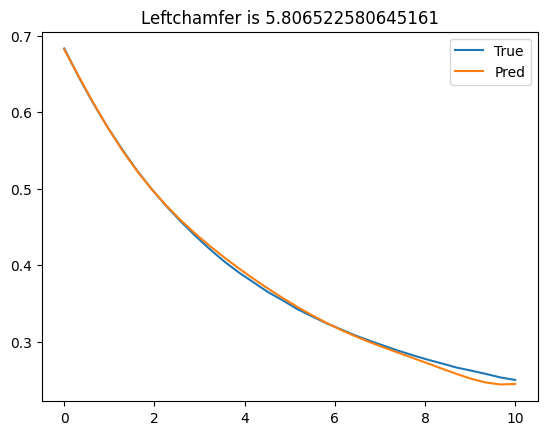

In [ ]:
value = df['Leftchamfer'].iloc[np.random.randint(1_000)]
df_helper = df[df['Leftchamfer'] == value]

plt.title(f'Leftchamfer is {value}')
plt.plot(df_helper['Rightchamfer'], df_helper['h6/h2'], label='True')
plt.plot(df_helper['Rightchamfer'], full_predict(models_h6, (df_helper[['Rightchamfer', 'Leftchamfer']] - x_mean) / x_std), label='Pred')
plt.legend()

In [ ]:
m, s = (y_test - y_pred).mean(), (y_test - y_pred).std(ddof=1)

<Axes: xlabel='h14/h2', ylabel='Count'>

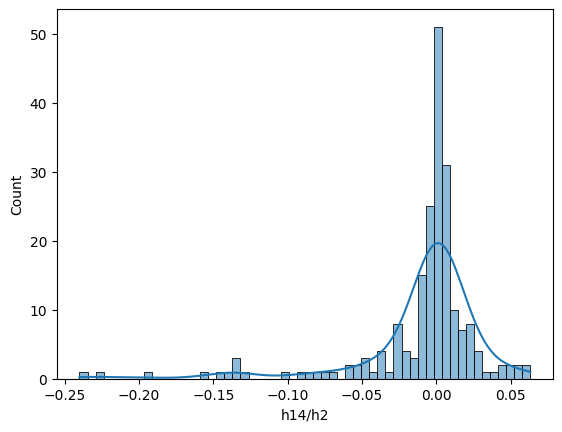

In [ ]:
sns.histplot((y_test - y_pred), kde=True)

# Сделаем более гладкие картинки

In [ ]:
leftchamfer = (np.linspace(df['Leftchamfer'].min(), df['Leftchamfer'].max(), 500) - x_mean['Leftchamfer']) / x_std['Leftchamfer']
rightchamfer = (np.linspace(df['Rightchamfer'].min(), df['Rightchamfer'].max(), 500) - x_mean['Rightchamfer']) / x_std['Rightchamfer']

surf = pd.DataFrame()
total = 0

for r in tqdm(rightchamfer):
    for l in leftchamfer:
        # Создаем двумерный массив для предсказания
        prediction_input = np.array([[r, l]])  # Двумерный массив
        prediction = full_predict(models_h6, prediction_input)
        r_param, l_param = (np.array([[r, l]]) * x_std.values + x_mean.values).flatten()

        # Создаем DataFrame с предсказанием
        surf = pd.concat([surf, pd.DataFrame({'Leftchamfer': [l_param], 'Rightchamfer': [r_param], 'h16/h2': prediction[0]})], ignore_index=True)

100%|██████████| 500/500 [12:54<00:00,  1.55s/it]


In [ ]:
# surf.columns = ['Rightchamfer', 'Leftchamfer', 'h14/h2']
surf.to_csv('svr_h6.csv', index=False)

<Axes: xlabel='Rightchamfer', ylabel='Leftchamfer'>

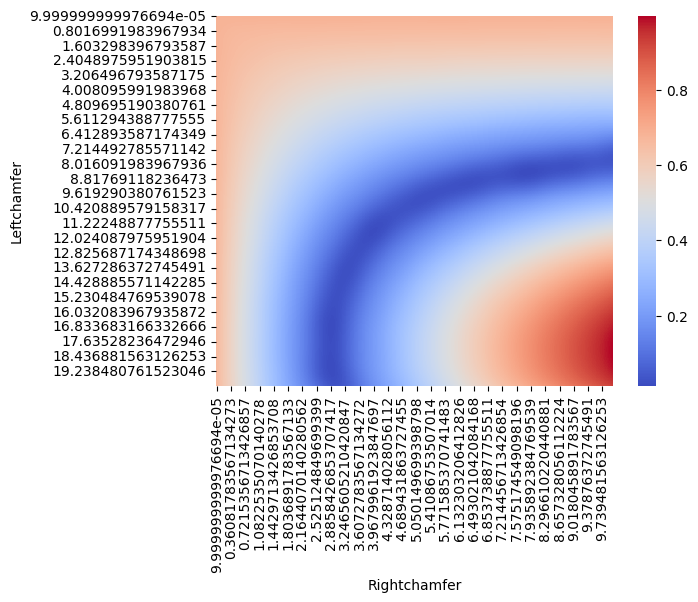

In [ ]:
sns.heatmap(pd.pivot_table(surf,
               index='Leftchamfer',
               columns='Rightchamfer',
               values='h16/h2',
               aggfunc='mean'),
            cmap="coolwarm"
)

# Настало время спуститься градиентом

In [ ]:
x = (np.array([[2, 4]]) - x_mean.values) / x_std.values
print(x)
dx = np.array([[0, 0.01]])
pred = full_predict(models_h6, x)
((full_predict(models_h6, x + dx) - pred) / 0.01 * np.sign(pred))[0]

[[-1.01864751 -0.99277708]]


-0.21196527512158392

In [ ]:
shape_history = []

def loss(x): # лосс это сумма предсказаний по всем моделям models_h6, models_h10, models_h14
    y_pred = np.zeros((x.shape[0]))
    for mods in all_models:
        y_pred += full_predict(mods, x)
    y_pred += abs(full_predict(models_h6, x) - full_predict(models_h10, x))
    return y_pred


def dldx1(x, eps=1e-5):
    dx = np.array([[eps, 0]])
    local_grad = 0
    for mods in all_models:
        pred = full_predict(mods, x)
        local_grad += ((full_predict(mods, x + dx) - pred) / eps * np.sign(pred))
    return local_grad

def dldx2(x, eps=1e-5):
    dx = np.array([[0, eps]])
    local_grad = 0
    for mods in all_models:
        pred = full_predict(mods, x)
        local_grad += ((full_predict(mods, x + dx) - pred) / eps * np.sign(pred))
    return local_grad


test_shape = ((np.array([2, 18]) - x_mean) / x_std).values.reshape(1, 2)
loss_hist = [loss(test_shape).flatten()[0]]

l= 1e-2
for epoch in tqdm(range(1000)):
    if epoch % 1000 == 0 and epoch != 0:
        l /= 3
    grad = np.array([dldx1(test_shape), dldx2(test_shape)]).reshape(test_shape.shape)
    test_shape = test_shape - l * grad
    loss_hist.append(loss(test_shape).flatten()[0])
    shape_history.append((test_shape * x_std.values + x_mean.values).flatten())

    if epoch % 100 == 0:
        print(loss_hist[-1])
        print(f'shape is {test_shape * x_std.values + x_mean.values}')

  0%|          | 4/1000 [00:00<00:29, 33.60it/s]

0.5857564324052651
shape is [[ 2.01362354 17.97280586]]


 11%|█         | 106/1000 [00:03<00:28, 31.20it/s]

0.26592702830180937
shape is [[ 2.81128583 16.3127557 ]]


 20%|██        | 205/1000 [00:06<00:25, 31.23it/s]

0.25409658103185867
shape is [[ 2.92465763 16.2006858 ]]


 30%|███       | 303/1000 [00:11<00:40, 17.24it/s]

0.2534936864760785
shape is [[ 2.93679608 16.19623892]]


 40%|████      | 405/1000 [00:15<00:19, 30.76it/s]

0.2534417205494881
shape is [[ 2.93807852 16.19598518]]


 50%|█████     | 505/1000 [00:18<00:16, 30.54it/s]

0.2534364978385843
shape is [[ 2.93821353 16.19596423]]


 60%|██████    | 605/1000 [00:21<00:12, 30.41it/s]

0.25343596486100545
shape is [[ 2.93822778 16.19596253]]


 64%|██████▍   | 644/1000 [00:23<00:12, 27.63it/s]


KeyboardInterrupt: 

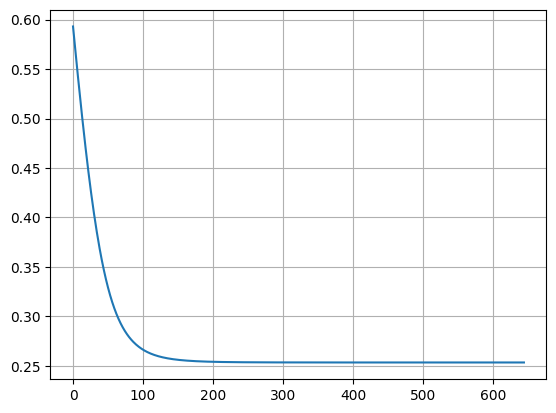

In [ ]:
plt.plot(loss_hist)
plt.grid()

Что вписать в скрипт для создания .comi файла

In [ ]:
end_shape = (test_shape.flatten() * x_std + x_mean).values.flatten()
right, left = end_shape[0], end_shape[1]
print(f'r, l = {right}, {left}')

r, l = 2.938228798088884, 16.19596210921747


In [ ]:
df[df['h6/h2'] == df['h6/h2'].min()]

,Rightchamfer,Leftchamfer,h2,h6,h10,h14,h6/h2,h10/h2,h14/h2,Prod,target_reg_group
342,3.225874193548387,14.193577419354838,0.127122379774117,0.000003246857189,0.000784613046839,0.000167507523017,0.0,0.221798804468226,0.148196706840098,45.786695111227885,group_0


# Изобразим картинки хорошего расширения вместе

In [ ]:
df_h6 = pd.read_csv('exetended_harmonic_data/svr_h6.csv')
df_h10 = pd.read_csv('exetended_harmonic_data/svr_h10.csv')
df_h14 = pd.read_csv('exetended_harmonic_data/svr_h14.csv')


df_h6['h6/h2'] = (df_h6['h6/h2'] - df_h6['h6/h2'].min())/(df_h6['h6/h2'].max() - df_h6['h6/h2'].min())
df_h10['h10/h2'] = (df_h10['h10/h2'] - df_h10['h10/h2'].min())/(df_h10['h10/h2'].max() - df_h10['h10/h2'].min())
df_h14['h14/h2'] = (df_h14['h14/h2'] - df_h14['h14/h2'].min())/(df_h14['h14/h2'].max() - df_h14['h14/h2'].min())

pivot_h6 = pd.pivot_table(df_h6, index='Leftchamfer', columns='Rightchamfer', values='h6/h2', aggfunc='mean')
pivot_h10 = pd.pivot_table(df_h10, index='Leftchamfer', columns='Rightchamfer', values='h10/h2', aggfunc='mean')
pivot_h14 = pd.pivot_table(df_h14, index='Leftchamfer', columns='Rightchamfer', values='h14/h2', aggfunc='mean')

Точку минимума мы нашли на изначальных графиках 32х32. Найдем на нашем новом графике ближайшую к ней

In [ ]:
right_on_pictures_raw = pivot_h6.columns[abs(pivot_h6.columns - rightchamfer_raw).argmin()]
left_on_pictures_raw = pivot_h6.index[abs(pivot_h6.index - leftchamfer_raw).argmin()]

right_on_pictures_raw, left_on_pictures_raw

(2.905882565130261, 15.470964529058117)

График без конечной точки

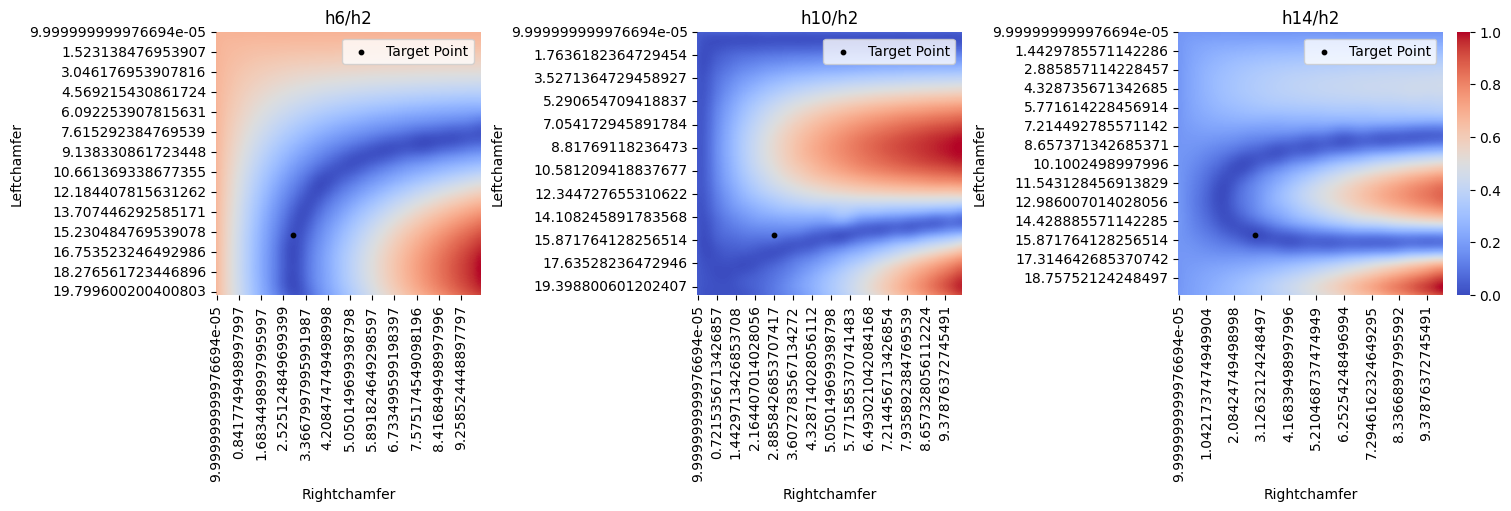

In [ ]:
def round_to_three(x, pos):
    return f'{x:.3f}'

N_bins = 14
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# Heatmap 1
pivot_h6 = pd.pivot_table(df_h6, index='Leftchamfer', columns='Rightchamfer', values='h6/h2', aggfunc='mean')
sns.heatmap(pivot_h6, ax=axes[0], cmap="coolwarm", cbar=False)
axes[0].set_title("h6/h2")

# Наносим точку
axes[0].scatter(
    x=[pivot_h6.columns.get_loc(right_on_pictures_raw)],  # Индекс столбца
    y=[pivot_h6.index.get_loc(left_on_pictures_raw)],  # Индекс строки
    color="black", s=10, label="Target Point"
)



axes[0].legend(loc="upper right")
axes[0].locator_params(axis='x', nbins=N_bins)
axes[0].locator_params(axis='y', nbins=N_bins)

# Heatmap 2
sns.heatmap(pivot_h10, ax=axes[1], cmap="coolwarm", cbar=False)
axes[1].set_title("h10/h2")

# Наносим точку
axes[1].scatter(
    x=[pivot_h6.columns.get_loc(right_on_pictures_raw)],  # Индекс столбца
    y=[pivot_h6.index.get_loc(left_on_pictures_raw)],  # Индекс строки
    color="black", s=10, label="Target Point"
)
# Наносим конечную точку

axes[1].legend(loc="upper right")
axes[1].locator_params(axis='x', nbins=N_bins)
axes[1].locator_params(axis='y', nbins=N_bins)

# Heatmap 3
sns.heatmap(pivot_h14, ax=axes[2], cmap="coolwarm")
axes[2].set_title("h14/h2")

# Наносим точку
axes[2].scatter(
    x=[pivot_h6.columns.get_loc(right_on_pictures_raw)],  # Индекс столбца
    y=[pivot_h6.index.get_loc(left_on_pictures_raw)],  # Индекс строки
    color="black", s=10, label="Target Point"
)

axes[2].legend(loc="upper right")
axes[2].locator_params(axis='x', nbins=N_bins)
axes[2].locator_params(axis='y', nbins=N_bins + 3)

plt.show()

Параметры сырой точки по 32х32

In [ ]:
# Параметры нашей точки
print('Rightchamfer', rightchamfer_raw, '\n', 'Leftchamfer', leftchamfer_raw)

Rightchamfer 2.9032967741935485 
 Leftchamfer 15.483893548387096


Параметры найденной точки мл моделью

In [ ]:
print('Rightchamfer', right, '\n', 'Leftchamfer', left)

Rightchamfer 2.938228798088884 
 Leftchamfer 16.19596210921747


Параметры чтобы нанести на график

In [ ]:
right_on_pictures = pivot_h6.columns[abs(pivot_h6.columns - right).argmin()]
left_on_pictures = pivot_h6.index[abs(pivot_h6.index - left).argmin()]

print('Rightchamfer', right_on_pictures, '\n', 'Leftchamfer', left_on_pictures)

Rightchamfer 2.9459623246492987 
 Leftchamfer 16.192403807615232


Результат работы мл алгоритма

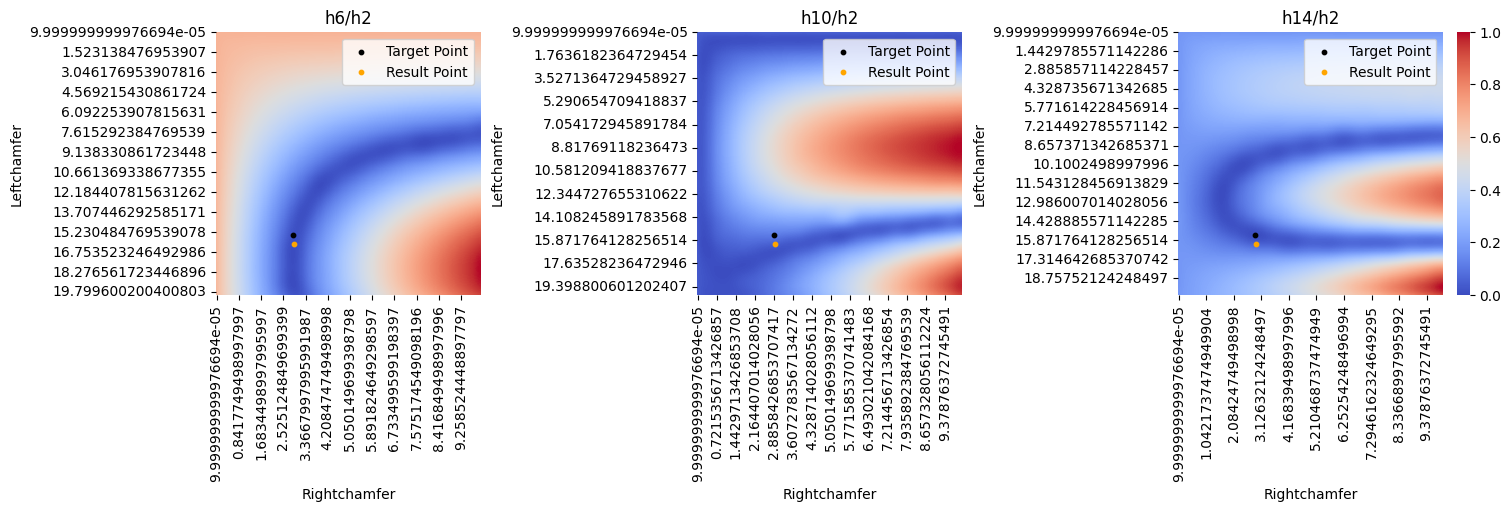

In [ ]:
def round_to_three(x, pos):
    return f'{x:.3f}'

N_bins = 14
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# Heatmap 1
sns.heatmap(pivot_h6, ax=axes[0], cmap="coolwarm", cbar=False)
axes[0].set_title("h6/h2")

# Наносим точку
axes[0].scatter(
    x=[pivot_h6.columns.get_loc(right_on_pictures_raw)],  # Индекс столбца
    y=[pivot_h6.index.get_loc(left_on_pictures_raw)],  # Индекс строки
    color="black", s=10, label="Target Point"
)

# Наносим конечную точку
axes[0].scatter(
    x=[pivot_h14.columns.get_loc(right_on_pictures)],  # Индекс столбца
    y=[pivot_h14.index.get_loc(left_on_pictures)],  # Индекс строки
    color="orange", s=10, label="Result Point"
)

axes[0].legend(loc="upper right")
axes[0].locator_params(axis='x', nbins=N_bins)
axes[0].locator_params(axis='y', nbins=N_bins)

# Heatmap 2
sns.heatmap(pivot_h10, ax=axes[1], cmap="coolwarm", cbar=False)
axes[1].set_title("h10/h2")

# Наносим точку
axes[1].scatter(
    x=[pivot_h6.columns.get_loc(right_on_pictures_raw)],  # Индекс столбца
    y=[pivot_h6.index.get_loc(left_on_pictures_raw)],  # Индекс строки
    color="black", s=10, label="Target Point"
)
# Наносим конечную точку
axes[1].scatter(
    x=[pivot_h14.columns.get_loc(right_on_pictures)],  # Индекс столбца
    y=[pivot_h14.index.get_loc(left_on_pictures)],  # Индекс строки
    color="orange", s=10, label="Result Point"
)
axes[1].legend(loc="upper right")
axes[1].locator_params(axis='x', nbins=N_bins)
axes[1].locator_params(axis='y', nbins=N_bins)

# Heatmap 3
sns.heatmap(pivot_h14, ax=axes[2], cmap="coolwarm")
axes[2].set_title("h14/h2")

# Наносим точку
axes[2].scatter(
    x=[pivot_h6.columns.get_loc(right_on_pictures_raw)],  # Индекс столбца
    y=[pivot_h6.index.get_loc(left_on_pictures_raw)],  # Индекс строки
    color="black", s=10, label="Target Point"
)
# Наносим конечную точку
axes[2].scatter(
    x=[pivot_h14.columns.get_loc(right_on_pictures)],  # Индекс столбца
    y=[pivot_h14.index.get_loc(left_on_pictures)],  # Индекс строки
    color="orange", s=10, label="Result Point"
)
axes[2].legend(loc="upper right")
axes[2].locator_params(axis='x', nbins=N_bins)
axes[2].locator_params(axis='y', nbins=N_bins + 3)

plt.show()

Посмотрим на метрику перебором и мл моделью

In [ ]:
print(f'loss на параметрах с помощью модели {loss((np.array([right, left]).reshape(1, 2) - x_mean.values) / x_std.values)[0]}')
print(f'loss на параметрах с помощью перебора {loss((np.array([rightchamfer_raw, leftchamfer_raw]).reshape(1, 2) - x_mean.values) / x_std.values)[0]}')

loss на параметрах с помощью модели 0.25343591621312855
loss на параметрах с помощью перебора 0.29945267186744384


In [ ]:
(loss((np.array([right, left]).reshape(1, 2) - x_mean.values) / x_std.values)[0]) / (loss((np.array([rightchamfer_raw, leftchamfer_raw]).reshape(1, 2) - x_mean.values) / x_std.values)[0])

0.846330455603064